# Understanding the Causal Convolution 3D()

#####  Q 0.1.  ```time_pad = self.dilation * (self.time_kernel_size - 1)```

ANS -> It appears you've provided a line of code, `time_pad = self.dilation * (self.time_kernel_size - 1)`, likely from a machine learning model, particularly one involving convolutional neural networks with a temporal dimension.

This line of code is calculating the padding needed for a 1D convolution operation along the time axis. Let's break down the components and the purpose of this calculation:

* **`self.dilation`**: This refers to the dilation rate of the convolution. Dilation (also known as atrous convolution) is a technique that introduces gaps between the kernel's elements. A dilation rate of 1 means no gaps (a standard convolution). A rate of 2 means there's one gap between each element. This allows the convolution to have a wider receptive field without increasing the number of parameters or computational cost.

* **`self.time_kernel_size`**: This is the size of the convolutional kernel along the time dimension. For example, a `time_kernel_size` of 3 means the kernel looks at 3 consecutive time steps.

* **`time_pad`**: This is the resulting padding value. Padding is the process of adding extra "pixels" (or, in this case, time steps) to the input tensor's edges. This is done to ensure that the output tensor has a similar size to the input, preventing the output from shrinking with each layer.

**Why this specific formula?**

This formula, `dilation * (kernel_size - 1)`, is a standard way to calculate the required padding for a "same" or "causal" convolution.

* **For "same" convolution**: The goal is for the output sequence to have the same length as the input sequence. The formula ensures that the input and output sizes match.
* **For "causal" convolution**: This is common in models processing time-series data (like WaveNet or TCNs). A causal convolution ensures that the prediction at a given time step only depends on past and current time steps, not future ones. The padding calculation helps maintain the causality and the output sequence length.

**Example:**

Let's say you have a `time_kernel_size` of 3 and a `dilation` of 2.

`time_pad = 2 * (3 - 1) = 2 * 2 = 4`

This means you would need to add 4 time steps of padding to your input sequence to maintain the output size. The padding is usually applied to the beginning of the sequence in a causal setup.

---

##### Q 0.2 can you teach me why this time_causal_padding in this order: self.time_causal_padding = (self.width_pad, self.width_pad, self.height_pad, self.height_pad, self.time_pad, 0) -> (1, 1, 1, 1, 2, 0) 

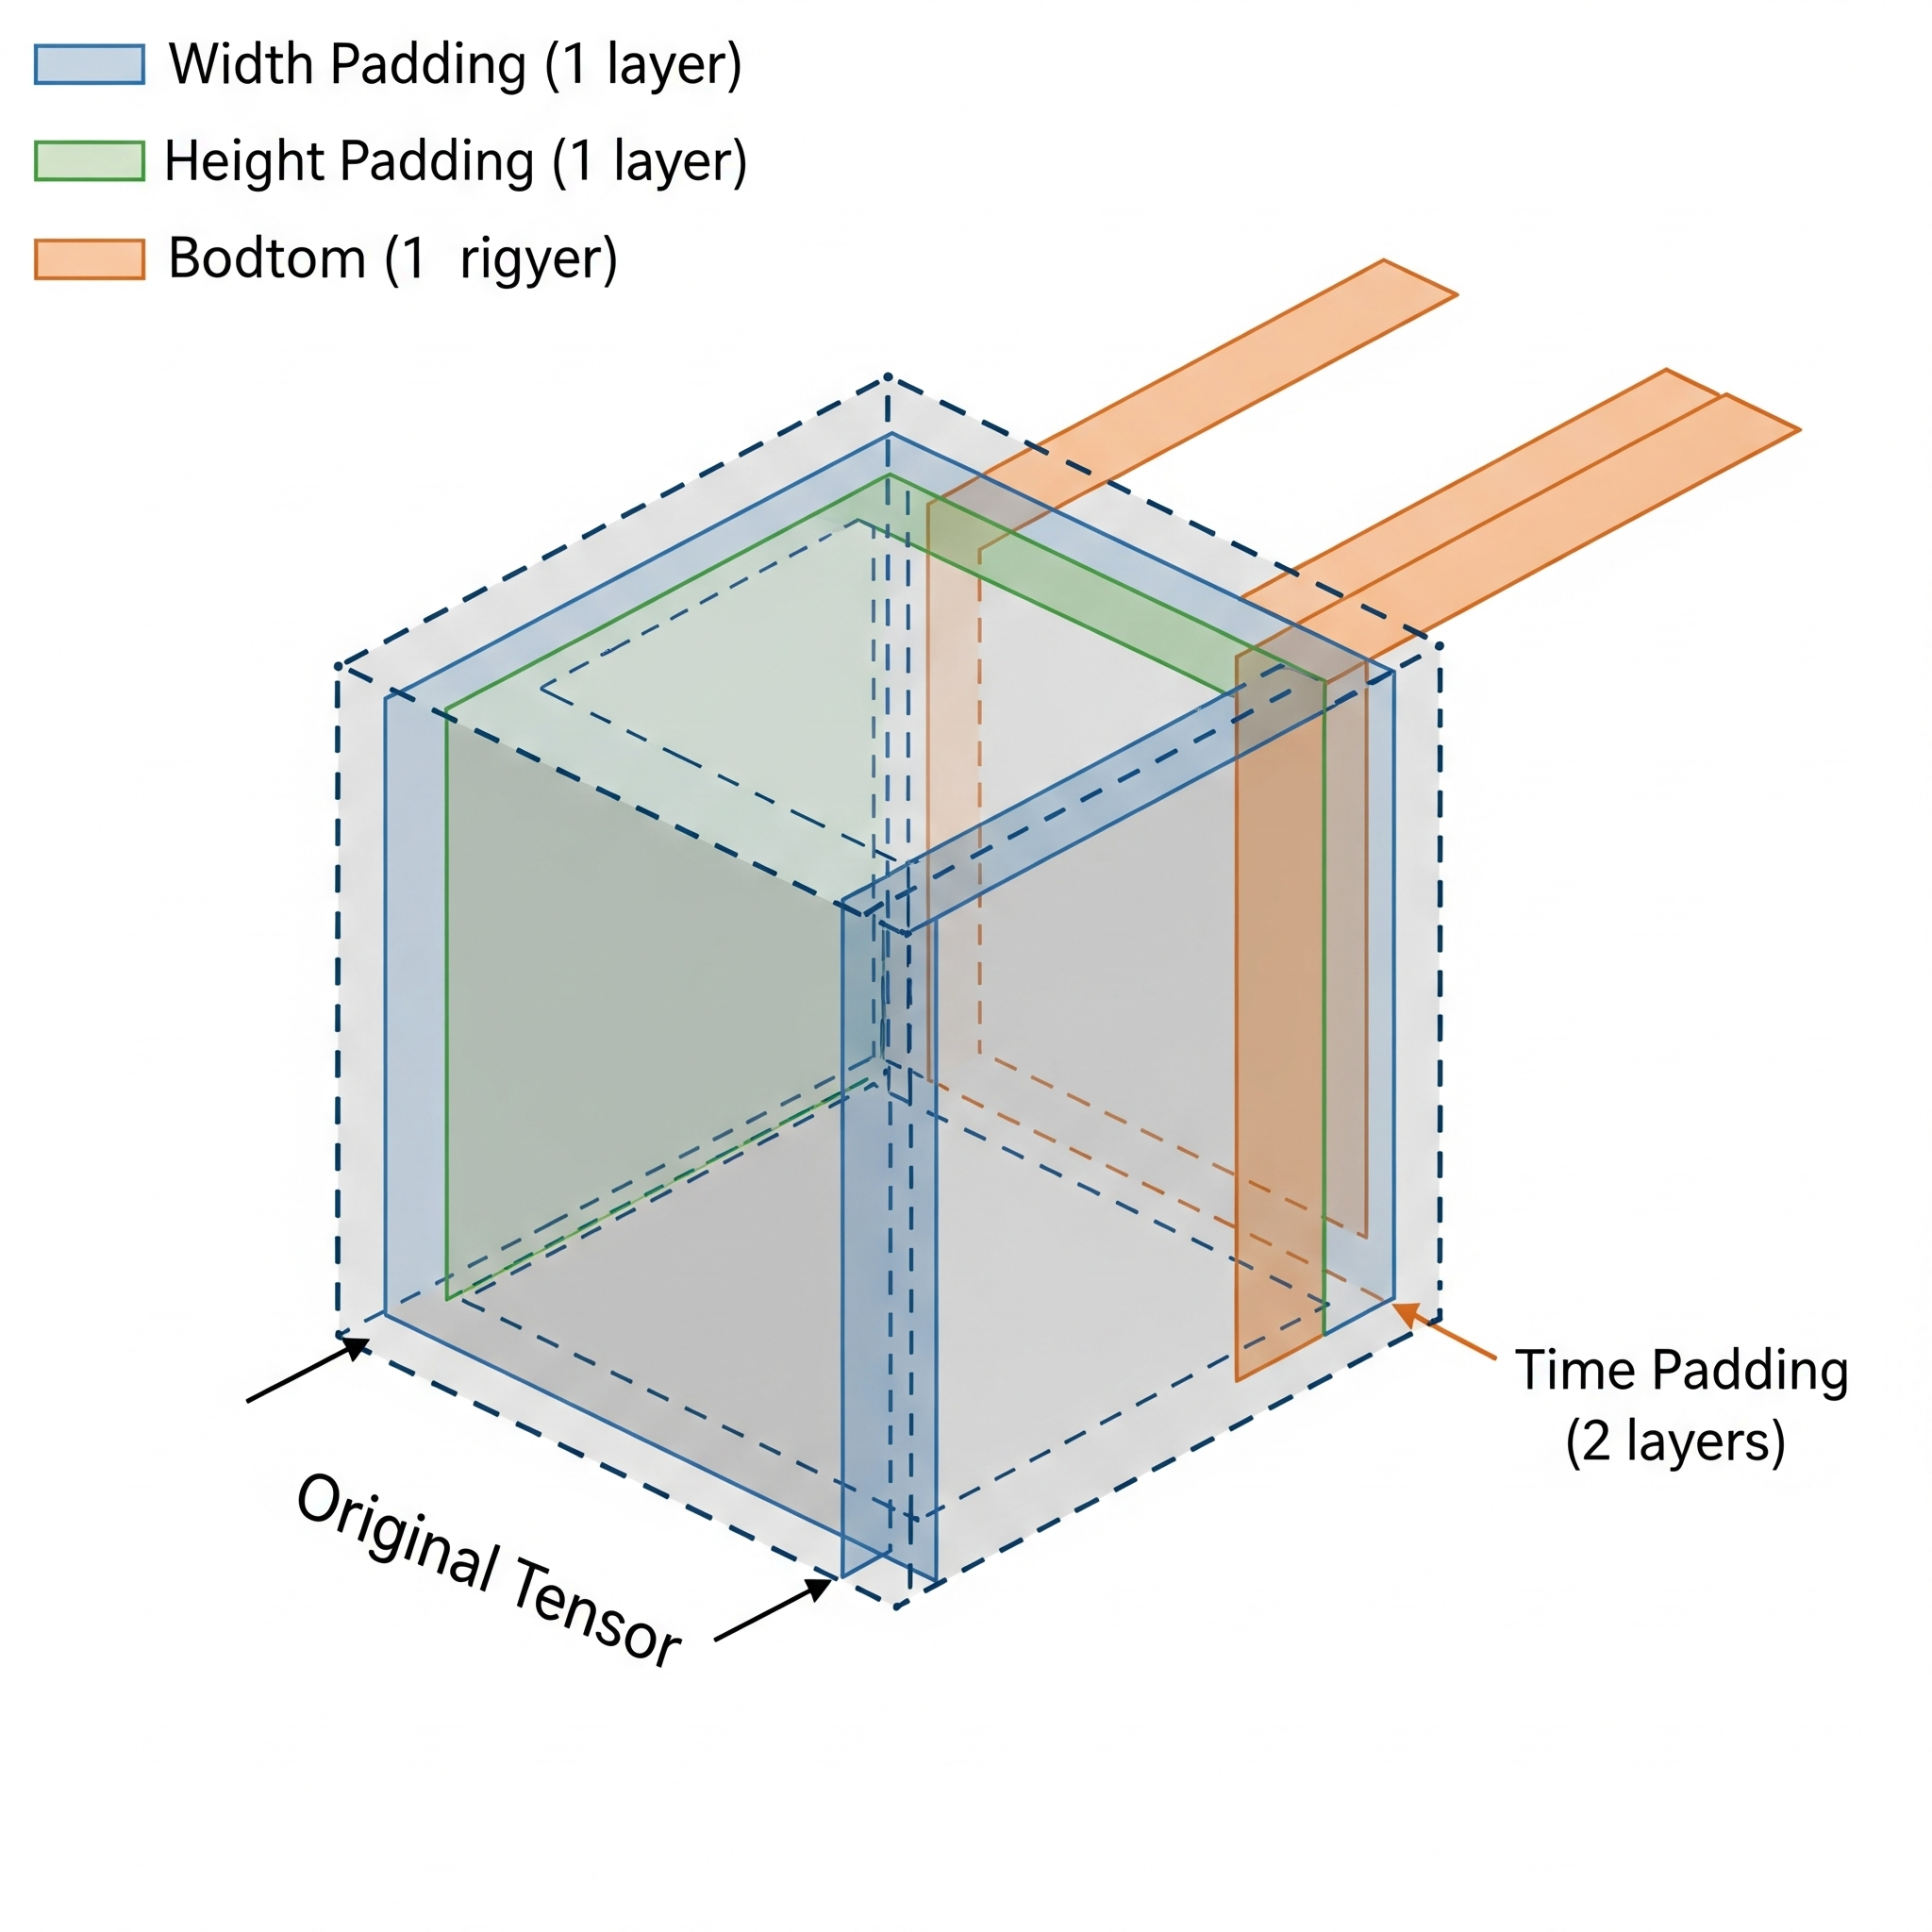

That's a great question, and it gets to the heart of how 3D convolutions and causal padding work together. The line you've provided:

`self.time_causal_padding = (self.width_pad, self.width_pad, self.height_pad, self.height_pad, self.time_pad, 0)`

And its potential resulting value:

`(1, 1, 1, 1, 2, 0)`

This is a specific format for padding a 5D tensor (a common shape for video or 3D data) in a deep learning framework like PyTorch. Let's break down why it's in this specific order.

### The 5D Tensor and Padding

In deep learning, especially with video data, a tensor often has this shape: `(batch_size, channels, time, height, width)`. This is a 5D tensor.

When you apply a 3D convolution, you're convolving a kernel across three dimensions: time, height, and width. The padding needs to be specified for each of these three dimensions, and for both sides of the dimension (the beginning and the end).

The padding format you've shown, `(left_width_pad, right_width_pad, top_height_pad, bottom_height_pad, start_time_pad, end_time_pad)`, is a common convention, particularly in PyTorch's `F.pad` or a similar function. Let's map your example to this convention.

### Deconstructing the Padding Tuple

`self.time_causal_padding = (self.width_pad, self.width_pad, self.height_pad, self.height_pad, self.time_pad, 0)`

* **`(self.width_pad, self.width_pad)`**: This pair specifies the padding for the width dimension. The first value is for the left side (or beginning) of the width, and the second is for the right side (or end). In your example, `(1, 1)`, this means 1 unit of padding is added to both the left and right sides of the width dimension. This is typical for "same" padding, where you want to maintain the width of the input.

* **`(self.height_pad, self.height_pad)`**: Similarly, this pair handles the padding for the height dimension. The first value is for the top, and the second is for the bottom. In your example, `(1, 1)`, this adds 1 unit of padding to both the top and bottom of the height dimension, again to maintain the height.

* **`(self.time_pad, 0)`**: This is the crucial part that relates to **causal padding**.
    * `self.time_pad`: This is the padding applied to the **beginning** of the time dimension. It's the `time_pad` value you calculated earlier, likely `dilation * (kernel_size - 1)`.
    * `0`: This is the padding applied to the **end** of the time dimension. It's set to zero.

### Why the `(time_pad, 0)` Order is Causal

This specific padding format is what makes the convolution "causal." A causal convolution is one where the output at a given time step depends only on the current and **past** time steps, not future ones.

Let's imagine your input sequence has a time dimension of `T`.

* **Standard (non-causal) padding:** If you wanted to maintain the time dimension's size and not worry about causality, you might split the padding evenly, for example, `(time_pad // 2, time_pad - (time_pad // 2))`. This would add padding to both the beginning and the end of the time dimension. A convolution at time step `t` could then "see" both `t-1` and `t+1` of the padded input, making it non-causal.

* **Causal padding:** By putting all the padding at the **beginning** of the time dimension (`self.time_pad`) and **none** at the end (`0`), you ensure that the convolution at any given time step `t` can only see data up to and including the original `t`. It will never "see" a future time step from the original sequence.

Think of it like this: The padding at the beginning gives the first few time steps of the output something to "look back" at. If you had no padding, the first output would only depend on the first few inputs, and the "receptive field" would be small. By adding padding at the start, you're effectively providing "dummy" past data so that the convolution can operate consistently across the entire sequence.

### Summary

The padding tuple `(width_pad, width_pad, height_pad, height_pad, time_pad, 0)` is a specific and standard way to prepare a 5D video or 3D data tensor for a causal 3D convolution.

* The pairs for width and height (`width_pad, width_pad` and `height_pad, height_pad`) are for **same padding**, ensuring the output's spatial dimensions remain consistent with the input.
* The time pair (`time_pad, 0`) is specifically for **causal padding**, adding all the necessary padding to the beginning of the sequence and none to the end. This is a critical design choice in temporal models to prevent information from "leaking" from the future into the past.